In [2]:
import sys
print("Python", sys.version)

Python 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [ ]:
#------------ INSTALACIÓN DE LIBRERIAS NECESARIAS -------------

!pip install torch torchvision pandas matplotlib scikit-learn tensorboard kaggle
import os
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

   ---------------------------------------- 0.0/181.2 kB ? eta -:--:--
   -------------------------------------- - 174.1/181.2 kB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 181.2/181.2 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/163.4 kB ? eta -:--:--
   ---------------------------------------- 163.4/163.4 kB ? eta 0:00:00
   ---------------------------------------- 0.0/78.2 kB ? eta -:--:--
   ---------------------------------------- 78.2/78.2 kB ? eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\juanp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# ----------- Descarga del dataset desde kaggle ----------------------

from kaggle.api.kaggle_api_extended import KaggleApi
import os

api = KaggleApi()
api.authenticate()

# Dataset de conducción distractiva
dataset = 'arafatsahinafridi/multi-class-driver-behavior-image-dataset'

# Directorio destino
project_dir = os.getcwd()   # C:\Users\juanp\Desktop\Proyecto-3
raw_dir = os.path.join(project_dir, 'data', 'raw')
os.makedirs(raw_dir, exist_ok=True)

# Descarga y descompresión
api.dataset_download_files(dataset, path=raw_dir, unzip=True, quiet=False)
print("Dataset listo en:", raw_dir)

Dataset URL: https://www.kaggle.com/datasets/arafatsahinafridi/multi-class-driver-behavior-image-dataset


100%|██████████| 2.38G/2.38G [00:01<00:00, 1.54GB/s]



✓ Dataset listo en: c:\Users\juanp\Desktop\Proyecto-3\data\raw


In [ ]:
# ------------ BLOQUE PARA SABER LAS CLASES DEL DATASET ----------------
# %%  
import os

project_dir = os.getcwd()
raw_dir = os.path.join(project_dir, 'data', 'raw')

# 1. Mostrar carpetas de primer nivel en raw_dir
print("Carpetas en data/raw:")
print(os.listdir(raw_dir))

# 2. Suponiendo que hay una única carpeta principal, entrar ahí
inner = os.listdir(raw_dir)[0]
inner_path = os.path.join(raw_dir, inner)
print(f"\nClases detectadas en '{inner}':")
print(os.listdir(inner_path))



Carpetas en data/raw:
['Multi-Class Driver Behavior Image Dataset']

Clases detectadas en 'Multi-Class Driver Behavior Image Dataset':
['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']


In [ ]:
# ----------------- PREPROCESAMIENTO Y PARTICIONES ----------------------
# %%  
import os
import random
import shutil

project_dir = os.getcwd()
raw_dir = os.path.join(project_dir, 'data', 'raw')
# Nombre de la carpeta interna que contiene las clases
inner = os.listdir(raw_dir)[0]
inner_path = os.path.join(raw_dir, inner)

# Directorio donde guardaremos los splits
split_root = os.path.join(project_dir, 'data', 'full_split')

# 1. Limpiamos cualquier ejecución previa
if os.path.exists(split_root):
    shutil.rmtree(split_root)

# 2. Creamos la estructura de carpetas vacías
for split in ['train','val','test']:
    for cls in os.listdir(inner_path):
        os.makedirs(os.path.join(split_root, split, cls), exist_ok=True)

# 3. Definimos proporciones
proportions = {'train': 0.70, 'val': 0.15, 'test': 0.15}

# 4. Repartimos los archivos de cada clase
for cls in os.listdir(inner_path):
    cls_dir = os.path.join(inner_path, cls)
    files = os.listdir(cls_dir)
    random.shuffle(files)
    n = len(files)
    n_train = int(proportions['train'] * n)
    n_val   = int(proportions['val']   * n)
    # Cortes en el array
    train_files = files[:n_train]
    val_files   = files[n_train:n_train + n_val]
    test_files  = files[n_train + n_val:]
    # Copiamos a cada carpeta
    for fname in train_files:
        shutil.copy(os.path.join(cls_dir, fname),
                    os.path.join(split_root, 'train', cls, fname))
    for fname in val_files:
        shutil.copy(os.path.join(cls_dir, fname),
                    os.path.join(split_root, 'val', cls, fname))
    for fname in test_files:
        shutil.copy(os.path.join(cls_dir, fname),
                    os.path.join(split_root, 'test', cls, fname))

print("Splits creados en:", split_root)
# Comprueba conteos
for split in ['train','val','test']:
    total = sum(len(os.listdir(os.path.join(split_root, split, cls))) 
                for cls in os.listdir(inner_path))
    print(f"  • {split}: {total} imágenes")


✓ Splits creados en: c:\Users\juanp\Desktop\Proyecto-3\data\full_split
  • train: 5091 imágenes
  • val: 1088 imágenes
  • test: 1097 imágenes


In [ ]:

# ------------- BLOQUE DE AUGMENTATIONS ---------------
# %%  
from torchvision import transforms
from torchvision.transforms import RandomErasing

# Transformaciones para entrenamiento con RandomErasing
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    RandomErasing(p=0.5, scale=(0.02,0.2)),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std= [0.229,0.224,0.225]),
])

# Transformaciones para validación y test (sin augmentations fuertes)
val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std= [0.229,0.224,0.225]),
])



In [ ]:
# --------------- DATALOADERS -----------------
# %%  
import os
from torchvision import datasets
from torch.utils.data import DataLoader

project_dir = os.getcwd()
split_root  = os.path.join(project_dir, 'data', 'full_split')

# Datasets a partir de carpetas
train_ds = datasets.ImageFolder(
    os.path.join(split_root, 'train'),
    transform=train_transforms)

val_ds   = datasets.ImageFolder(
    os.path.join(split_root, 'val'),
    transform=val_test_transforms)

test_ds  = datasets.ImageFolder(
    os.path.join(split_root, 'test'),
    transform=val_test_transforms)

# DataLoaders
batch_size = 32

train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    shuffle=True,  num_workers=2, pin_memory=True)

val_loader   = DataLoader(
    val_ds,   batch_size=batch_size,
    shuffle=False, num_workers=2, pin_memory=True)

test_loader  = DataLoader(
    test_ds,  batch_size=batch_size,
    shuffle=False, num_workers=2, pin_memory=True)

# Comprobación rápida
print(f"Train: {len(train_ds)} imágenes — clases: {train_ds.classes}")
print(f" Val : {len(val_ds)} imágenes")
print(f" Test: {len(test_ds)} imágenes")


Train: 5091 imágenes — clases: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']
 Val : 1088 imágenes
 Test: 1097 imágenes


In [ ]:
# ---------------- CARGAR RED RESNET-18------------------
# %%  
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# Detectar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Cargar ResNet-18 preentrenada
base_model = models.resnet18(pretrained=True)

# 2. Congelar todos los parámetros
for param in base_model.parameters():
    param.requires_grad = False

# 3. Descongelar layer3 y layer4 (bloques finales)
for name, param in base_model.named_parameters():
    if name.startswith('layer3') or name.startswith('layer4'):
        param.requires_grad = True

# 4. Reemplazar la capa fully-connected final
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, len(train_ds.classes))
)

# 5. Mover a dispositivo
model = base_model.to(device)

# 6. Recoger parámetros entrenables
params_to_update = [p for p in model.parameters() if p.requires_grad]
print(f"Parámetros entrenables: {sum(p.numel() for p in params_to_update)}")

# 7. Definir optimizador con lr muy bajo
optimizer = optim.Adam(params_to_update, lr=1e-5)

# 8. Definir función de pérdida (puedes añadir weights aquí si quieres)
criterion = nn.CrossEntropyLoss()

print("Modelo listo: fine‑tuning de layer3+4 con lr=1e-5")



C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parámetros entrenables: 10559749
Modelo listo: fine‑tuning de layer3+4 con lr=1e-5


In [ ]:
# ----------------- CANTIDAD DE PARAMETROS ENTRENABLES ------------------------
# %%
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer solo para los parámetros de la nueva fc
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

print("Parámetros entrenables:", 
      sum(p.numel() for p in model.parameters() if p.requires_grad))


Parámetros entrenables: 10559749


In [ ]:
# -------------- DEFINICIÓN DE FUNCIONES  EVALUATE Y TRAIN PER EPOCH--------------------
# %%  
import torch
from sklearn.metrics import accuracy_score

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

print("Funciones train_one_epoch y evaluate definidas.")


Funciones train_one_epoch y evaluate definidas.


In [ ]:
# -------------------- ENTRENAMIENTO DEL MODELO -------------------
# %%  
import time
from sklearn.metrics import accuracy_score

# Early stopping
num_epochs = 40
best_acc = 0.0
patience = 7
counter = 0
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

start_time = time.time()
for epoch in range(1, num_epochs+1):
    # Entrenamiento
    train_loss, train_acc = train_one_epoch(model, train_loader,
                                            criterion, optimizer, device)
    # Validación
    val_loss, val_acc     = evaluate(model, val_loader,
                                      criterion, device)

    # Guardar historial
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch:02d}/{num_epochs} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping / guardar mejor
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
        print(f"  ✔️ Mejor modelo guardado (val_acc={best_acc:.4f})")
    else:
        counter += 1
        if counter >= patience:
            print(f" Early stopping tras {counter} épocas sin mejora.")
            break

total_time = time.time() - start_time
print(f"\n✓ Entrenamiento completo en {total_time/60:.1f} min. Mejor val_acc: {best_acc:.4f}")




C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/40 | Train Acc: 0.3461 | Val Acc: 0.5009
  ✔️ Mejor modelo guardado (val_acc=0.5009)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 02/40 | Train Acc: 0.4903 | Val Acc: 0.6094
  ✔️ Mejor modelo guardado (val_acc=0.6094)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 03/40 | Train Acc: 0.5353 | Val Acc: 0.6048


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 04/40 | Train Acc: 0.5525 | Val Acc: 0.6627
  ✔️ Mejor modelo guardado (val_acc=0.6627)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 05/40 | Train Acc: 0.5527 | Val Acc: 0.6985
  ✔️ Mejor modelo guardado (val_acc=0.6985)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 06/40 | Train Acc: 0.5714 | Val Acc: 0.6719


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 07/40 | Train Acc: 0.5830 | Val Acc: 0.6893


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 08/40 | Train Acc: 0.5965 | Val Acc: 0.7298
  ✔️ Mejor modelo guardado (val_acc=0.7298)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 09/40 | Train Acc: 0.5987 | Val Acc: 0.7307
  ✔️ Mejor modelo guardado (val_acc=0.7307)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/40 | Train Acc: 0.5903 | Val Acc: 0.7013


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11/40 | Train Acc: 0.6030 | Val Acc: 0.7289


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12/40 | Train Acc: 0.6091 | Val Acc: 0.7381
  ✔️ Mejor modelo guardado (val_acc=0.7381)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13/40 | Train Acc: 0.6105 | Val Acc: 0.7298


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14/40 | Train Acc: 0.6117 | Val Acc: 0.7472
  ✔️ Mejor modelo guardado (val_acc=0.7472)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15/40 | Train Acc: 0.6125 | Val Acc: 0.7123


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 16/40 | Train Acc: 0.6148 | Val Acc: 0.7518
  ✔️ Mejor modelo guardado (val_acc=0.7518)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 17/40 | Train Acc: 0.6235 | Val Acc: 0.7325


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 18/40 | Train Acc: 0.6315 | Val Acc: 0.7610
  ✔️ Mejor modelo guardado (val_acc=0.7610)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19/40 | Train Acc: 0.6394 | Val Acc: 0.7417


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 20/40 | Train Acc: 0.6295 | Val Acc: 0.7656
  ✔️ Mejor modelo guardado (val_acc=0.7656)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 21/40 | Train Acc: 0.6260 | Val Acc: 0.7500


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 22/40 | Train Acc: 0.6299 | Val Acc: 0.7904
  ✔️ Mejor modelo guardado (val_acc=0.7904)


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 23/40 | Train Acc: 0.6207 | Val Acc: 0.7767


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 24/40 | Train Acc: 0.6392 | Val Acc: 0.7592


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 25/40 | Train Acc: 0.6409 | Val Acc: 0.7702


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 26/40 | Train Acc: 0.6476 | Val Acc: 0.7528


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 27/40 | Train Acc: 0.6354 | Val Acc: 0.7656


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 28/40 | Train Acc: 0.6431 | Val Acc: 0.7748


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 29/40 | Train Acc: 0.6621 | Val Acc: 0.7767
🛑 Early stopping tras 7 épocas sin mejora.

✓ Entrenamiento completo en 78.3 min. Mejor val_acc: 0.7904


In [ ]:
# ---------- CARGA DEL MODELO PARA ANALIZAR SUS MÉTRICAS ----------------
# %%  
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reconstruir la ResNet18 fine‑tuneada
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, len(train_ds.classes))
)

# Cargar pesos
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)
model.eval()
print(" best_model.pth cargado, listo para inferencia en Test")


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ best_model.pth cargado, listo para inferencia en Test


In [ ]:
# ----------------- MÉTRICAS ---------------
# %%  
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Reporte y matriz
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de Confusión:\n", cm)


                  precision    recall  f1-score   support

other_activities       0.66      0.45      0.53       179
    safe_driving       0.81      0.87      0.84       253
   talking_phone       0.68      0.72      0.70       228
   texting_phone       0.71      0.84      0.77       235
         turning       0.87      0.82      0.84       202

        accuracy                           0.75      1097
       macro avg       0.75      0.74      0.74      1097
    weighted avg       0.75      0.75      0.75      1097

Matriz de Confusión:
 [[ 80  24  41  24  10]
 [ 10 219   9  11   4]
 [ 11  10 164  35   8]
 [ 11   9  15 197   3]
 [ 10   7  11   9 165]]


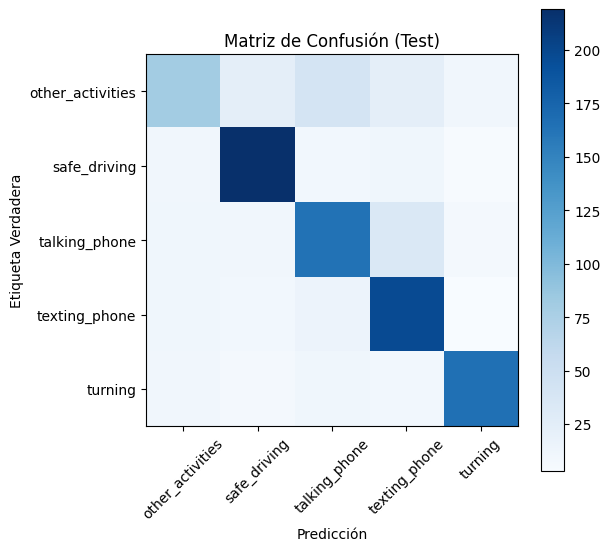

In [ ]:
#-------------- MATRIZ DE CONFUSIÓN -----------------

# %%  
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.xticks(range(len(train_ds.classes)), train_ds.classes, rotation=45)
plt.yticks(range(len(train_ds.classes)), train_ds.classes)
plt.colorbar()
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión (Test)')
plt.show()


C:\Users\juanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


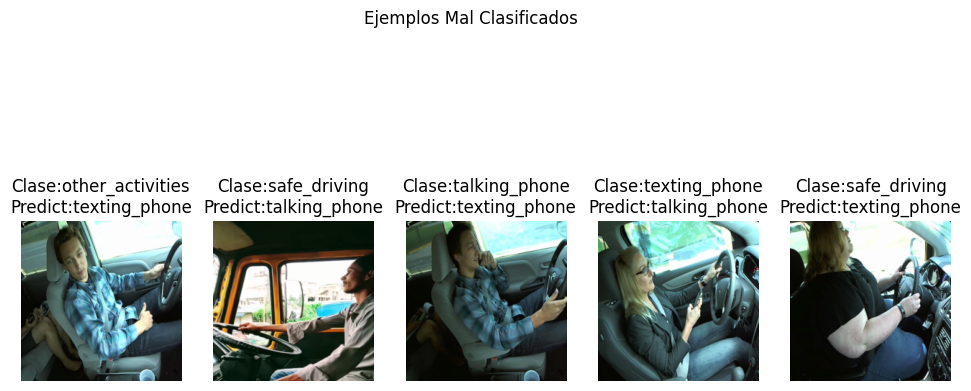

Total de imágenes mal clasificadas en test: 272 de 1097


In [ ]:
# ---------- EJEMPLOS MAL CLASIFICADOS (YA QUE EL MODELO NO TIENE 100% DE ACCURACY---------------
# %%  
import random
import matplotlib.pyplot as plt

# Selecciona 5 ejemplos mal clasificados
errors = [(img, true, pred) 
          for (img_batch, lbl_batch) in test_loader 
          for img, true, pred in zip(img_batch, lbl_batch.numpy(), 
                                     model(img_batch.to(device)).argmax(dim=1).cpu().numpy())
          if true != pred]

sample_errors = random.sample(errors, k=5)

plt.figure(figsize=(12,6))
for i, (img, true, pred) in enumerate(sample_errors, 1):
    ax = plt.subplot(1,5,i)
    img = img.permute(1,2,0).numpy()
    # des-normalizar (opcional, para mejor visual)
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Clase:{train_ds.classes[true]}\nPredict:{train_ds.classes[pred]}")
plt.suptitle("Ejemplos Mal Clasificados")
plt.show()

# Tras haber construido la lista 'errors' como en la celda anterior:
print(f"Total de imágenes mal clasificadas en test: {len(errors)} de {len(test_ds)}")
